# Diamox

Use this notebook for single animals, otherwise run it in batch from **GLUT1_Analysis**

In [137]:
import os
import subprocess
import numpy as np
import pandas as pd
import MRIhelperfunctions as h
import MRIhelperfunctions
from MRIhelperfunctions import Settings
from imp import importlib
import fnmatch
import papermill as pm

import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline  

from scipy.signal import savgol_filter
from scipy.stats import linregress

In [128]:
importlib.reload(h)
import MRIhelperfunctions as h
from MRIhelperfunctions import Settings

In [2]:
# Default Parameters (to run script independently)
folders = {}
folders['raw'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata'
folders['main'] = os.path.dirname(folders['raw'])
folders['analysis'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Analysis'
folders['animal'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/20180604_101508_Glut1_2_2'
folders['excel'] = 'Animal_Scan_IDs.xlsx'


animal = 'glut1_male1'


info = h.getinfo(folders)
info

,glut1_male1,glut1_male2,glut1_f10wks1,glut1_f10wks2,glut1_f10wks3,glut1_f10wks4,glut1_f10wks5,glut1_f10wks6,glut1_f8wks1,glut1_f8wks2,glut1_f8wks3,glut1_f8wks4,glut1_f8wks5,glut1_f8wks6,glut1_f8wks7,glut1_f6wks2,glut1_f6wks1
scan,,,,,,,,,,,,,,,,,
genotype,1,1,1,2,1,2,2,1,1,1,2,2,2,2,1,1,1
Gd DCE,6,8,6,5,5,8,5,5,7,5,6,6,8,8,6,5,5
Angio pre,8,9,7,6,6,9,6,6,8,6,9,8,9,9,8,6,6
Angio post,12,12,11,9,9,13,10,11,12,11,12,12,16,13,12,9,10
Endorem DCE,11,11,10,8,8,12,9,10,10,10,11,11,15,12,11,8,9
Diamox,15,14,13,11,13,15,12,13,14,13,16,17,20,16,14,11,13
folder,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...


In [131]:
# additional Script specific parameters

info = pd.read_json(info)  #<-- dont run this line in single animal mode

folders['template'] = os.path.join(folders['main'], 'Templates', 'BolusTracking.nii') # from animal glut1_male1
# BolusTracking has same geometry as Diamox scan, if not change above.
folders['in'] = os.path.join(folders['analysis'], animal)
folders['out'] = os.path.join(folders['in'], 'Diamox')

baseline = 290 # injection was after 300s, we cut off 10s



if not os.path.exists(folders['out']):
    os.makedirs(folders['out'] )

In [5]:
scans={}
scans['number'] = int(info.loc['Diamox', animal])

scans['raw'] = os.path.join(folders['in'], f"X{scans['number']}P1.nii")


raw = nib.load(scans['raw'])
print(f'check if these dimensions make sense: {raw.shape}')

check if these dimensions make sense: (80, 35, 10, 1500)


## Coregistration
no motion correction

In [7]:
# cut out a single repetition
scans['single'] = f"{folders['out']}/single_timepoint.nii"
h.runAFNI(f"3dTcat -prefix {scans['single']} {scans['raw']}'[0]'")

# cut off first 10 points
scans['cut'] = os.path.join(folders['out'], f"{scans['number']}_cut.nii")
h.runAFNI(f"3dTcat -prefix {scans['cut']} {scans['raw']}'[10..$]'")

# coregistration
scans['single_coreg'], scans['coreg'] = h.simple_coreg(folders['template'], scans['single'], scans['cut'], folders['out'])

3dTcat -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/Diamox/single_timepoint.nii /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/X15P1.nii'[0]'
3dTcat -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/Diamox/15_cut.nii /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/X15P1.nii'[10..$]'
3dAllineate -base /home/aic/BigHDD/MR_DATA/GLUT1/Templates/BolusTracking.nii -source /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/Diamox/single_timepoint.nii -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/Diamox/A_coreg.nii -cost ls -zclip -interp quintic -final wsinc5 -twopass -twoblur 2 -fineblur 0.5 -nmatch 80% -conv 0.01 -1Dparam_save /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/Diamox/1dparams.1D
3dAllineate -1Dparam_apply /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/Diamox/1dparams.1D -source /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/Diamox/15_cut.nii -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/Diamox/B_coreg

In [77]:
img = nib.load(scans['coreg'])
data = img.get_fdata()
hdr = img.header
print(hdr)


dimensions = Settings()
dimensions.t_res = hdr['pixdim'][4]

dimensions.x = hdr['dim'][1]
dimensions.y = hdr['dim'][2]
dimensions.z = hdr['dim'][3]

dimensions.affine=np.zeros((4,4))
dimensions.affine[0,:] = hdr['srow_x']
dimensions.affine[1,:] = hdr['srow_y']
dimensions.affine[2,:] = hdr['srow_z']




data_reshaped = data.reshape(-1, data.shape[-1]) # we keep the e.g. 1490 time points, but put flatten all voxels in 1D.

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 48
dim             : [   4   80   35   10 1490    1    1    1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.         0.2        0.2        0.50591666 1.         0.
 0.         0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 9
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.70710677
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -8.455814
qoffset_y       :

## Detrending

slope: 0.0014699641348983085, ttp: 723


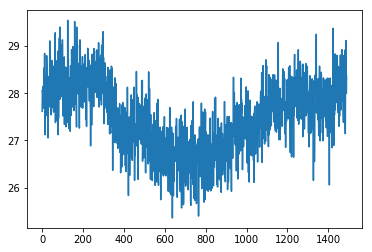

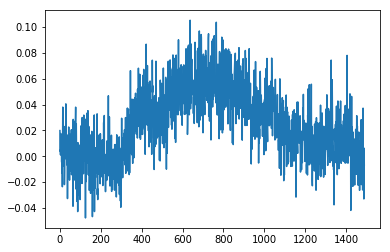

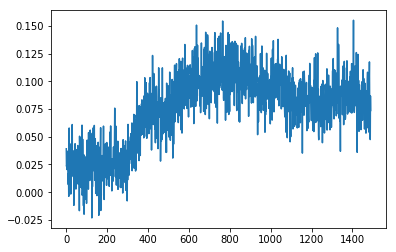

In [173]:
mrslice=80*35*7
voxelonslice = 80*14+33

x = data_reshaped[mrslice+voxelonslice,:]

plt.figure()
plt.plot(x)  # raw signal of that voxel


def prepare_data(raw_input, baseline):
    # continue with concentration  - K * ln( S(t) / S(0) )  (we ignore K)
    c = -np.log(raw_input / np.mean(raw_input[:baseline-5]))
    c_detrended, polyfit = h.custom_detrend(c, baseline-5)
    return c_detrended, c, polyfit


# to test single voxels, uncomment stuff below:

# c_detrended, c, polyfit = prepare_data(x, baseline)
# slope, ttp = diamox_find_parameters(c_detrended, baseline)  # execute function below first
# print(f"slope: {slope}, ttp: {ttp}")

# plt.figure()
# plt.plot(c)
# # plt.figure()
# # plt.plot(polyfit)
# plt.figure()
# plt.plot(c_detrended)

In [122]:
# run detrending for all voxels:
n_voxel = data_reshaped.shape[0]
detrended = np.zeros_like(data_reshaped)

for voxel in range(n_voxel):
    detrended[voxel,:], *_ = prepare_data(data_reshaped[voxel,:], baseline)

# save intermediate result, open in AFNI for quality check    
scans={}
scans['Detrended'] = h.save_nifti(detrended, dimensions, folders, animal, 'detrended_conc_curve')

## slope & TTP

In [168]:
def diamox_find_parameters(c_detrended, baseline):
    # smoothing
    c_smooth = savgol_filter(c_detrended, 19, 3) # window size, polynomial order

    # find first value after injection where signal returns to baseline value (to skip the dip artifact)
    bsl_value = np.mean(c_smooth[:baseline-5])
    start_point = np.argwhere(c_smooth[baseline+1:] >= bsl_value) + baseline+1
    try:
        start_point = int(start_point[0]) #in some noise voxels it never returns to baselien, not sure what to set there
    except:
        start_point = baseline

    # slope
    # do linear regression +- n_points around the zero point after injection. play around with the points if necessary
    points_before = 3 # points before zero crossing to consider
    points_after = 7 # points after zero crossing to consider

    y = c_smooth[start_point-points_before:start_point+points_after]
    x = np.arange(0,y.size)
    slope = linregress(x,y)
    slope = slope.slope

    # TTP
    # find the first point after the start point (defined above) where the signal reaches 95% of the absolute maximum
    # more robust than finding absolute max (double peaks, spikes somewhere etc.)
    max_point = np.argmax(c_smooth[start_point:])+start_point
    ttp  = np.argwhere(c_smooth[start_point:] >= 0.95*np.max(c_smooth[start_point:])) + start_point
    try:
        ttp = int(ttp[0]) #can be in noise regions that it never reaches this point
    except:
        ttp = 0
    return slope, ttp

In [169]:
# run it over all voxels

n_voxel = data_reshaped.shape[0]
slope = np.zeros(n_voxel)
ttp = np.zeros(n_voxel)

for voxel in range(n_voxel):
    slope[voxel], ttp[voxel]= diamox_find_parameters(detrended[voxel,:], baseline)

In [172]:
# save Nifti Files
scans={}
multiplication_factor = 1000
scans['diamox_slope'] = h.save_nifti(slope*multiplication_factor, dimensions, folders, animal, 'diamox_slope')
scans['diamox_ttp'] = h.save_nifti(ttp, dimensions, folders, animal, 'diamox_ttp')

# save directories papermill for the main notebook:
pm.record("diamox_slope", scans['diamox_slope'])
pm.record("diamox_ttp", scans['diamox_ttp'])